# Learning coins similarity
- http://pythonexample.com/code/image-similarity-tensorflow/
- https://github.com/debarko/CapsNet-Tensorflow
- https://github.com/XifengGuo/CapsNet-Keras

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
import pandas as pd

%run ../common/datasets.ipynb
%run ../common/visualisation.ipynb

%matplotlib inline

## Load data

In [44]:
def load_coins_dataset(ndata):
    return load_image_dataset(
        img_shape = [64, 64, 1],
        path      = "/netforge/datasets/private/roman/coins/images",
        ndata     = ndata)

In [387]:
data_size = 1200
(
    image_shape, 
    file_num,
    train_images, 
    train_labels, 
    test_images, 
    test_labels
) = load_coins_dataset(data_size)

print("File num   :", file_num)
print("Data size  :", data_size)
print("Train shape:", list(train_images.shape))
print("Test  shape:", list(test_images.shape))
print("Image shape:", image_shape)

File num   : 2400
Data size  : 1200
Train shape: [1200, 4096]
Test  shape: [1200, 4096]
Image shape: [64, 64, 1]


## Visualisation

Train images:


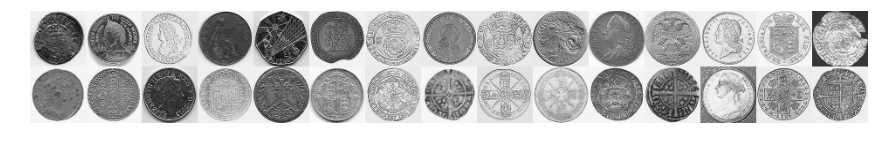

Test images:


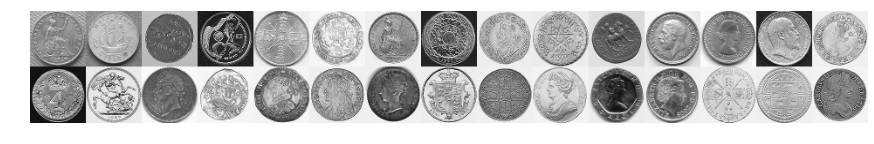

In [388]:
print("Train images:")
show_images(train_images, image_shape, rows=2, cols=15)
print("Test images:")
show_images(test_images, image_shape, rows=2, cols=15)

## TF Neural Networks

In [401]:
def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
    l = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=tf.nn.relu)
    return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)

def SimilarityNet(image1, image2):
    l = tf.concat([image1, image2], axis=1)
    l = conv2d_maxpool(l, 16)
    l = conv2d_maxpool(l, 32)
    l = conv2d_maxpool(l, 64)
    l = conv2d_maxpool(l, 128)
    l = conv2d_maxpool(l, 256)
    l = tf.contrib.layers.flatten(l)
    
    l = tf.layers.dense(l, units=800, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=2)
    logits = l
    pred   = tf.nn.softmax(logits)
    
    return logits, pred

def sim_loss(true, pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true, logits=pred))

### Graph

In [402]:
learning_rate = 1e-5
batch_size    = min(300, data_size // 2)
print("batch_size", batch_size)

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('similarity'):
        with tf.device('/gpu:0'):
            image1_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image1')
            image2_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image2')
            true_pl   = tf.placeholder(dtype=tf.float32, shape=[None, 2], name='true')
            logits_op, pred_op = SimilarityNet(image1_pl, image2_pl)
            loss_op   = sim_loss(true_pl, logits_op)
            train_op  = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)
            init_op   = tf.global_variables_initializer()

batch_size 300


### Augmentation

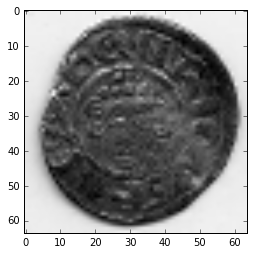

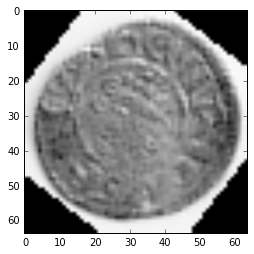

CPU times: user 656 ms, sys: 504 ms, total: 1.16 s
Wall time: 581 ms


In [413]:
%%time
from scipy.ndimage.interpolation import rotate

aug_cache = dict()
aug_num   = 84
def augment(im, use_cache=True):
    if use_cache:
        hc = hash(im.tostring())
        cached = aug_cache.get(hc, [])
        if len(cached)>=aug_num:
            return np.copy(cached[np.random.randint(aug_num)])

    im = np.copy(im)
    
    # brightness
    K = 1.5
    k = 1 + K*np.random.random(1) - K/2
    im = im * k
    
    # angle
    K = 90
    k = 2*K*np.random.random(1)-K
    im = rotate(im, k, reshape=False)

    # contrast
    k = np.random.choice([.5, 1, 2])
    im = np.power(np.abs(im), k)

    # normalize
    im = im/np.max(im)
    
    # inverse
    if np.random.random(1)>.5:
        im = 1-im

    # cache
    if use_cache:
        cached.append(im)
        aug_cache[hc] = cached
    return im

im = np.reshape(train_images[0], image_shape)
plt.imshow(np.reshape(im, image_shape[:2]), cmap='gray')
plt.show()
im = augment(im)
plt.imshow(np.reshape(im, image_shape[:2]), cmap='gray')
plt.show()


### Batching

['       1', '       1', '       1', '       1', '       0', '       0', '       1', '       1']


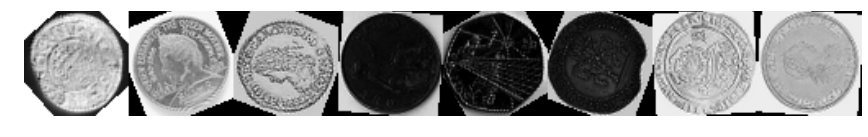

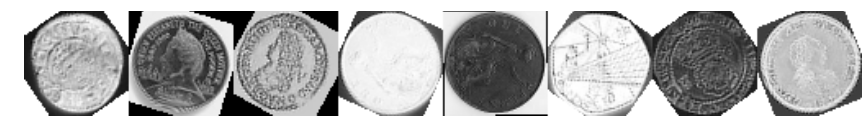

CPU times: user 572 ms, sys: 244 ms, total: 816 ms
Wall time: 517 ms


In [414]:
%%time
def get_next_batch(i, bs):
    img1 = np.copy(train_images[i:i+bs])
    
    per = np.arange(bs)
    per = np.roll(per, shift=1+np.random.randint(bs-1))
    
    img1 = np.reshape(img1, [-1,]+image_shape)
    img2 = img1[per]
    true = np.zeros([bs,2])
    same = np.random.randint(2, size=bs)
    
    for i in range(bs):
        true[i,same[i]] = 1.
        if same[i]:
            pass
            img2[i] = augment(img1[i])
            img1[i] = augment(img1[i])
        else:
            pass
            img1[i] = augment(img1[i])
            img2[i] = augment(img2[i])
            
    i = i + bs
    if i > len(train_images) - bs:
        i = 0
    
    return i, img1, img2, true

n = 8
_, im1, im2, t = get_next_batch(0, n)
print(["%8d"%t[i][1] for i in range(len(im1))])
show_images(im1, image_shape[:2], cols=n, rows=1)
show_images(im2, image_shape[:2], cols=n, rows=1)


### Train

In [415]:
try:
    sess.close()
except:
    pass
sess = tf.Session(graph=graph)
sess.run(init_op)

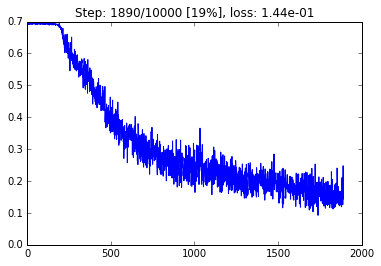

In [ ]:
%%time
def do_train(step_num, log_every=10):
    try:
        losses = []
        i = 0
        for step in range(step_num):
            i, img1, img2, true = get_next_batch(i, batch_size)
            _, loss = sess.run([train_op, loss_op], feed_dict={
                image1_pl: img1,
                image2_pl: img2,
                true_pl  : true
            })
            losses.append(loss)
            if step % log_every == log_every-1:
                show_losses(losses, step, step_num)
    except KeyboardInterrupt:
        pass
    show_losses(losses, step, step_num)
    
do_train(10000, 10)

### Find similar images

0.51 0.85 0.90 0.08 0.82 0.49 0.94 0.96 0.95 0.97 0.93 0.94
==== ==== ====      ====      ==== ==== ==== ==== ==== ====


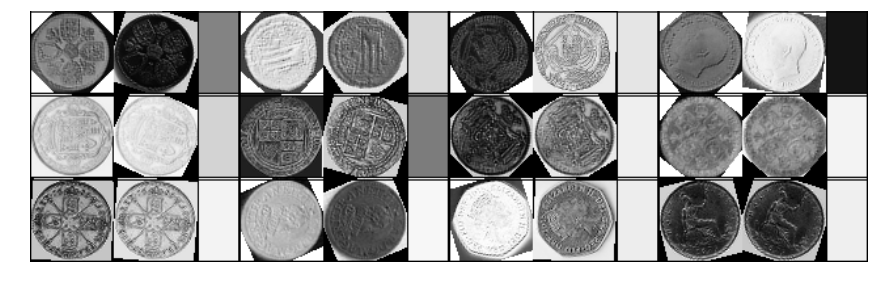

0.28 0.00 0.00 0.08 0.01 0.34 0.16 0.00 0.00 0.02 0.03 0.00
                                                           


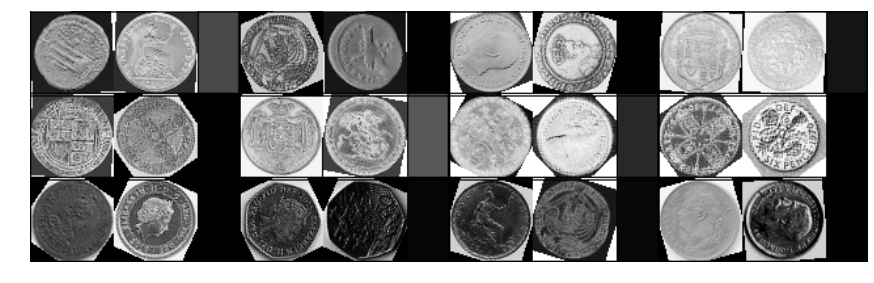

CPU times: user 904 ms, sys: 264 ms, total: 1.17 s
Wall time: 860 ms


In [400]:
%%time

def get_similarity(img1, img2, use_aug):
    img1 = np.copy(np.reshape(img1, [-1,]+image_shape))
    img2 = np.copy(np.reshape(img2, [-1,]+image_shape))
    if use_aug:
        for i in range(len(img2)):
            img1[i] = augment(img1[i], use_cache = False)
            img2[i] = augment(img2[i], use_cache = False)
    pred = sess.run(pred_op, feed_dict = {
        image1_pl: img1,
        image2_pl: img2
    })
    sim = pred[:,1]
    return img1, img2, sim


def test_similarity(images1, images2, num, use_aug=True):
    img1, img2, sim = get_similarity(images1[:num], images2[:num], use_aug)

    print(' '.join(['%.2f'%s for s in sim]))
    print(' '.join(['='*4 if s>.5 else ' '*4 for s in sim]))
    h  = image_shape[0]
    w  = image_shape[1]
    w3 = 32
    img1 = img1.reshape([num*h,w])
    img2 = img2.reshape([num*h,w])
    img3 = np.ones([num*h, w3])
    for i in range(num):
        s = sim[i]
        assert(0.<=s<=1.)
        img3[i*h:i*h+h] = s
    
    img1[:,0] = 0
    img3[:,w3-1] = 0
    img3[:,0] = 0
    sheet = np.concatenate([img1, img2, img3], axis=1)
    sheet[np.arange(0,h*num,h)-1,:] = 0
    sheet[np.arange(0,h*num,h)+1,:] = 0
    cols = 4
    sheet = np.minimum(sheet, 1)
    show_images(images=sheet, image_shape=[h, 2*w+w3], cols=cols, rows=num//cols)

num = 12
shift = np.random.randint(data_size-2*num)
test_similarity(
    images1  = test_images[shift:], 
    images2  = test_images[shift:], 
    num      = num)
test_similarity(
    images1  = test_images[shift+1:], 
    images2  = train_images[shift:], 
    num      = num)

### EOF